# Проект: классификация

Банки хранят огромные объёмы информации о своих клиентах. Эти данные можно использовать для того, чтобы оставаться на связи с клиентами и индивидуально ориентировать их на подходящие именно им продукты или банковские предложения.

Обычно с выбранными клиентами связываются напрямую через разные каналы связи: лично (например, при визите в банк), по телефону, по электронной почте, в мессенджерах и так далее. Этот вид маркетинга называется прямым маркетингом. На самом деле, прямой маркетинг используется для взаимодействия с клиентами в большинстве банков и страховых компаний. Но, разумеется, проведение маркетинговых кампаний и взаимодействие с клиентами — это трудозатратно и дорого.

→ Банкам хотелось бы уметь выбирать среди своих клиентов именно тех, которые с наибольшей вероятностью воспользуются тем или иным предложением, и связываться именно с ними.

Вам предоставили данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Вы должны проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Если вы сможете это сделать, то поднимете доходы банка и поможете понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

**Бизнес-задача:** определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

## Имеющиеся признаки:

**Данные о клиентах банка:**

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

**Прочие признаки:**

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её будем пытаться предсказать в данном кейсе.

### Загрузка данных

In [2]:
# Загрузим данные и проверим их
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head(5)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# Посмотрим основную информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
# Исследуем данные на предмет пропусков
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Посмотрим на категориальные признаки

In [5]:
df.describe(include='object')

,job,marital,education,default,balance,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11137,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,3802,2,2,3,12,4,2
top,management,married,secondary,no,0 $,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,774,5881,9702,8042,2824,8326,5873


In [6]:
# Посмотрим, какие уникальные значения имеют категориальные столбцы
# Возможно, пропуски обозначены каким-то специальным словом

object_cols = df.select_dtypes(include=['object']).columns.tolist()
object_cols.remove('month')
object_cols.remove('balance')

for col in object_cols:
    print(f'Уникальные категории для признка: {df[col].value_counts()}')
    print('___'*10)

Уникальные категории для признка: job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64
______________________________
Уникальные категории для признка: marital
married     6351
single      3518
divorced    1293
Name: count, dtype: int64
______________________________
Уникальные категории для признка: education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64
______________________________
Уникальные категории для признка: default
no     10994
yes      168
Name: count, dtype: int64
______________________________
Уникальные категории для признка: housing
no     5881
yes    5281
Name: count, dtype: int64
______________________________
Уникальные категории для признка: loan
no     9702
yes    1460
Name: c

### Преобразуем признак Balance в числовой вид

In [7]:
# преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace(' $','').str.replace(',','.').str.replace(' ','')
df['balance'] = pd.to_numeric(df['balance'])

### Заполним пропуски в нем медианным значением

In [8]:
# обработаем пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

### Заполним пропуски в признаках job и education

In [9]:
# обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x=='unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x=='unknown' else x)

### Найдем выбросы в признаке Balance

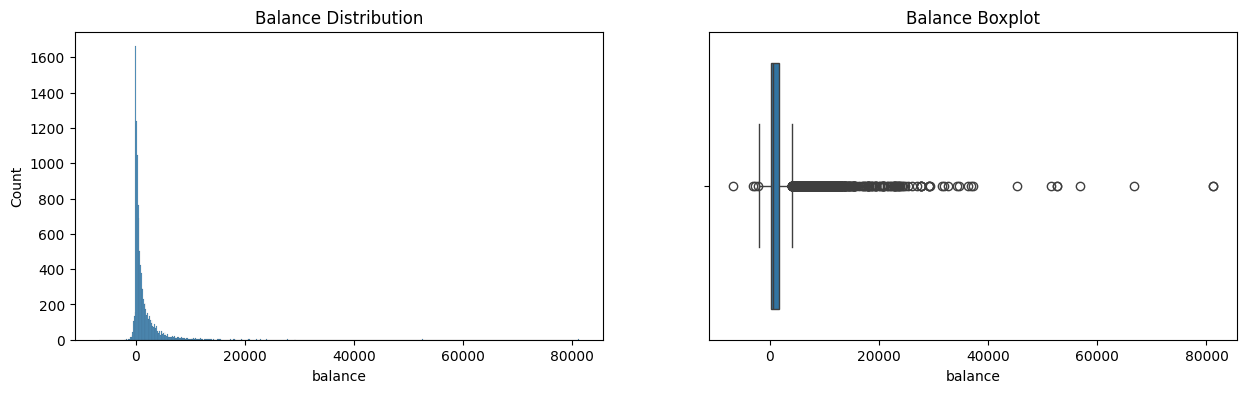

In [10]:
# Визуализируем распределение признака Balance

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0], log_scale=False);
histplot.set_title('Balance Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Balance Boxplot');

In [11]:
# По методу Тьюки найдем выбросы

def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_score=False):    
    if log_score:
        x = np.log(data[feature]+1)
    else:  
        x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (left*iqr)
    upper_bound = quartile_3 + (right*iqr)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned


outliers, cleaned= outliers_iqr_mod(df, 'balance', left=1.5,right=1.5, log_score=False)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


In [ ]:
# Удалим строки с выбросами
df = cleaned.reset_index().drop('index',axis=1)

In [13]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
10101,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
10102,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
10103,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


## Часть 2:  Разведывательный анализ

### Посмотрим на соотношение значений в цедевой переменной

In [14]:
df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

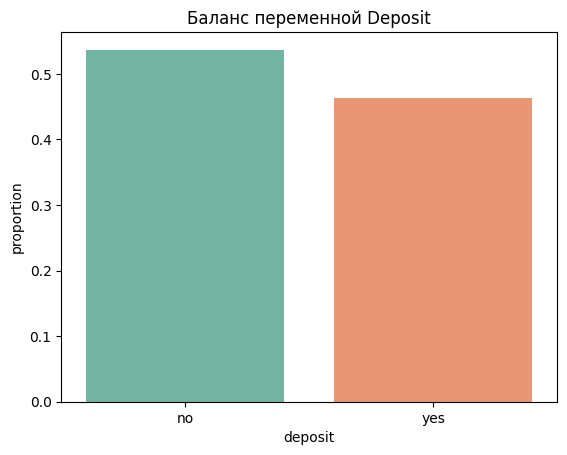

In [15]:
# Проверим соотношение классов в данных на предмет несбалансированности
barplot = sns.barplot(df['deposit'].value_counts(True),palette='Set2');
barplot.set_title(f'Баланс переменной Deposit')
plt.show()


Признак сбалансирован.

### Внимательнее посмотрим на числовые признаки

In [16]:
# Рассчитаем описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [17]:
to_plot = df.select_dtypes(include=['int','float']).columns.tolist()
to_plot

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

<Figure size 640x480 with 0 Axes>

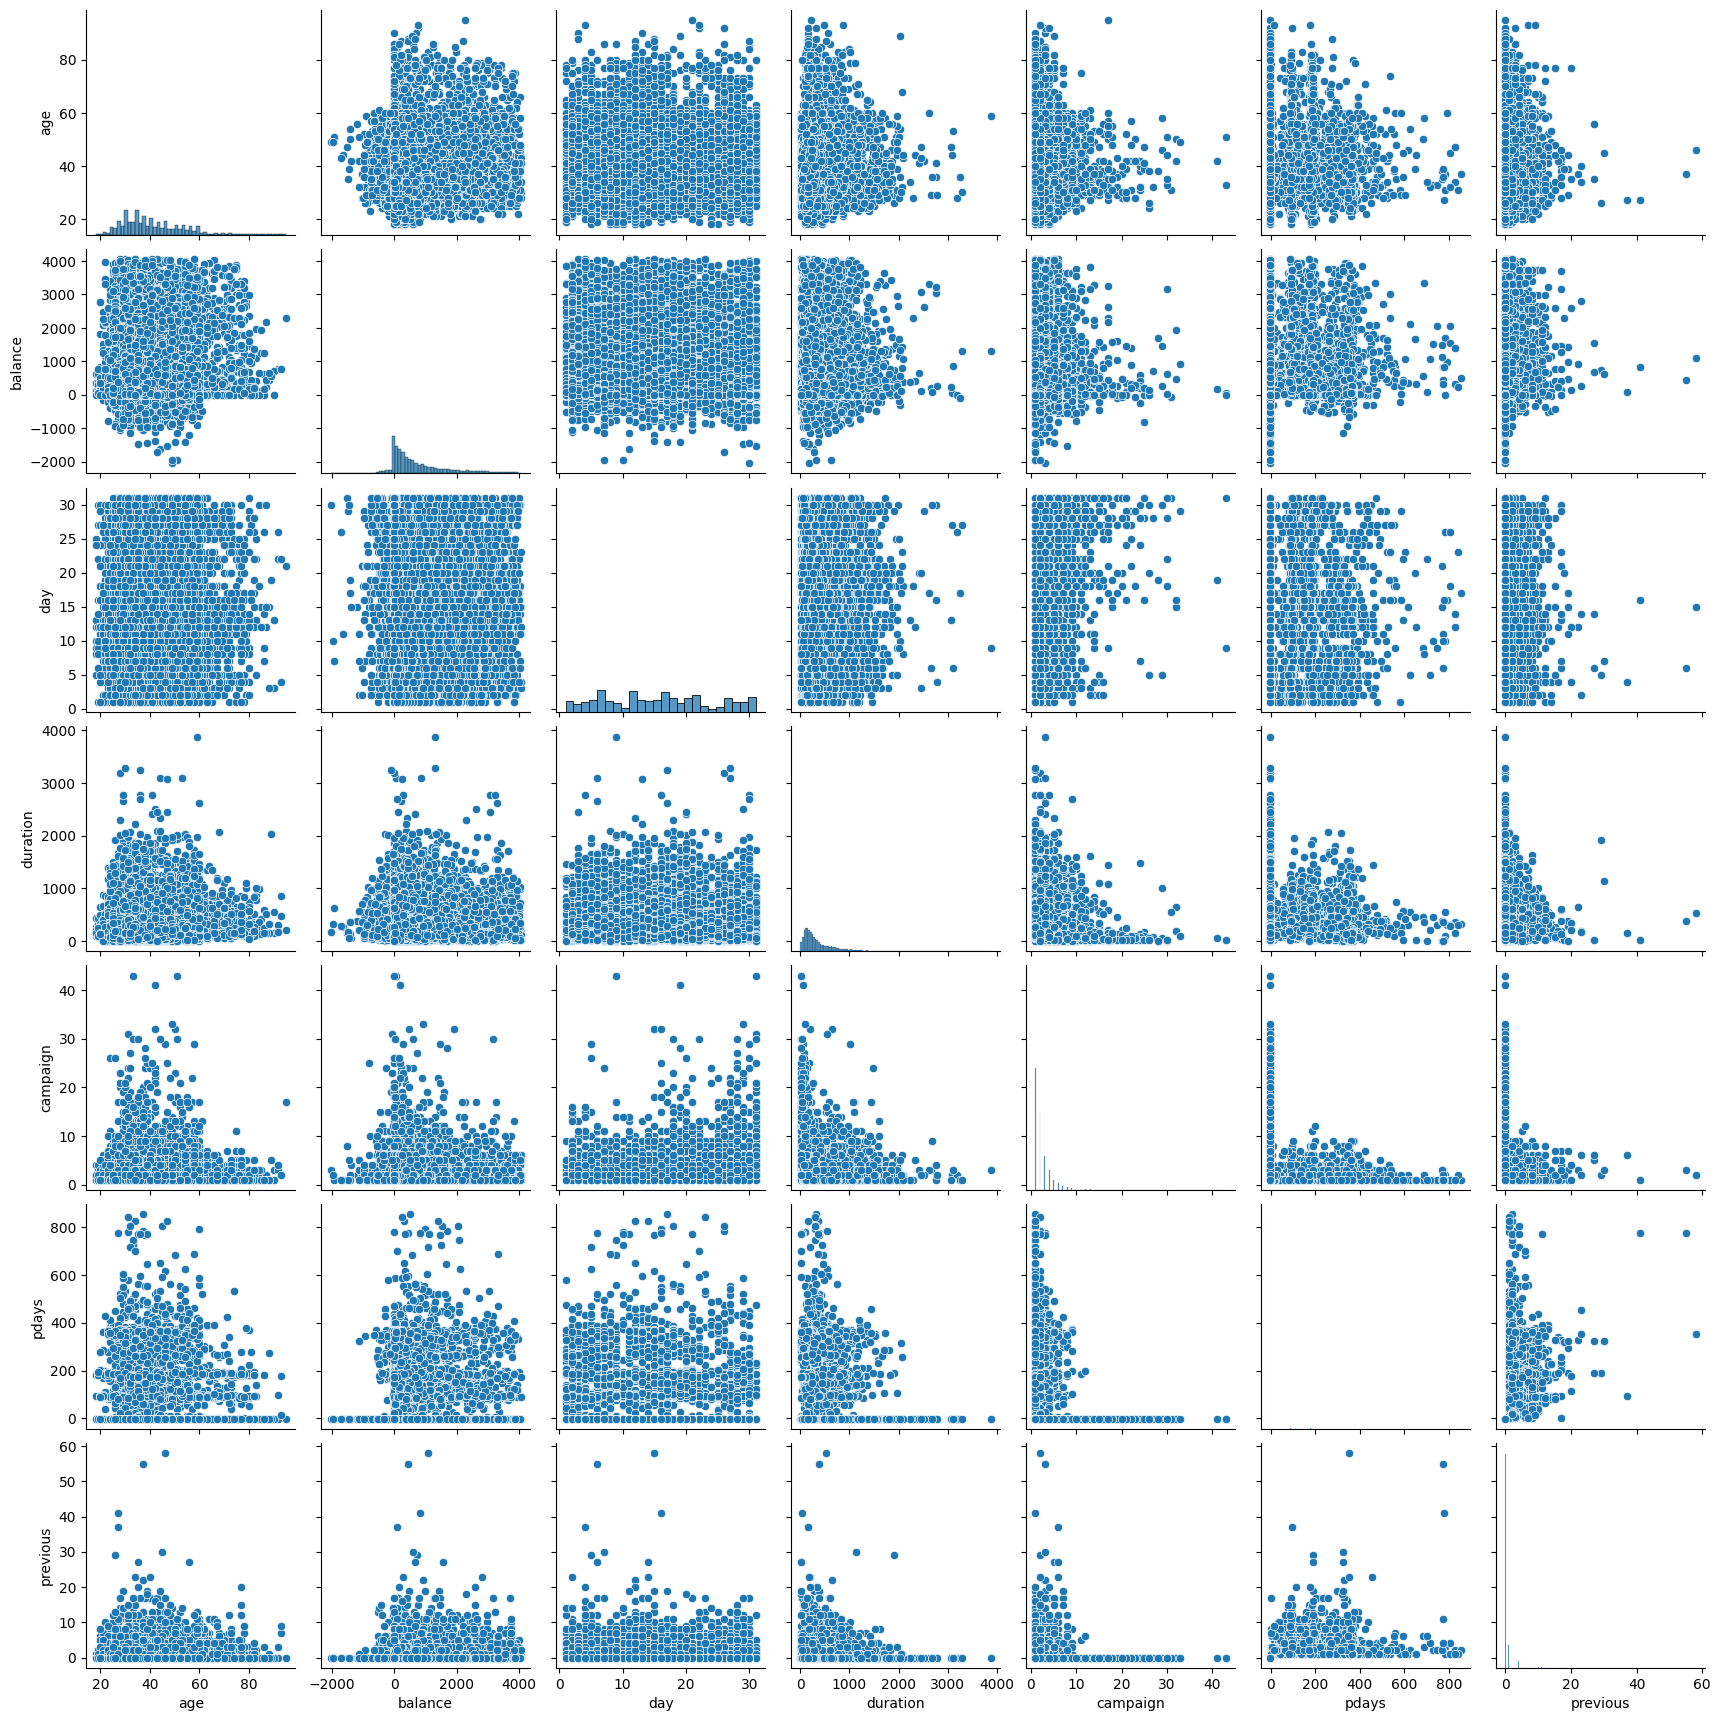

In [18]:
# Посмотрим на распределение признаков и их взаимозависимость
plt.figure()
sns.pairplot(df[to_plot])
plt.show()

### Исследуем категориальные признаки

In [19]:
#рассчитаем описательные статистики для категориальных переменных, проинтерпретируем результат
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


In [20]:
# Для удобства заменим значения в целевом признаке deposit на 1-открыл, 0 - не открыл
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)

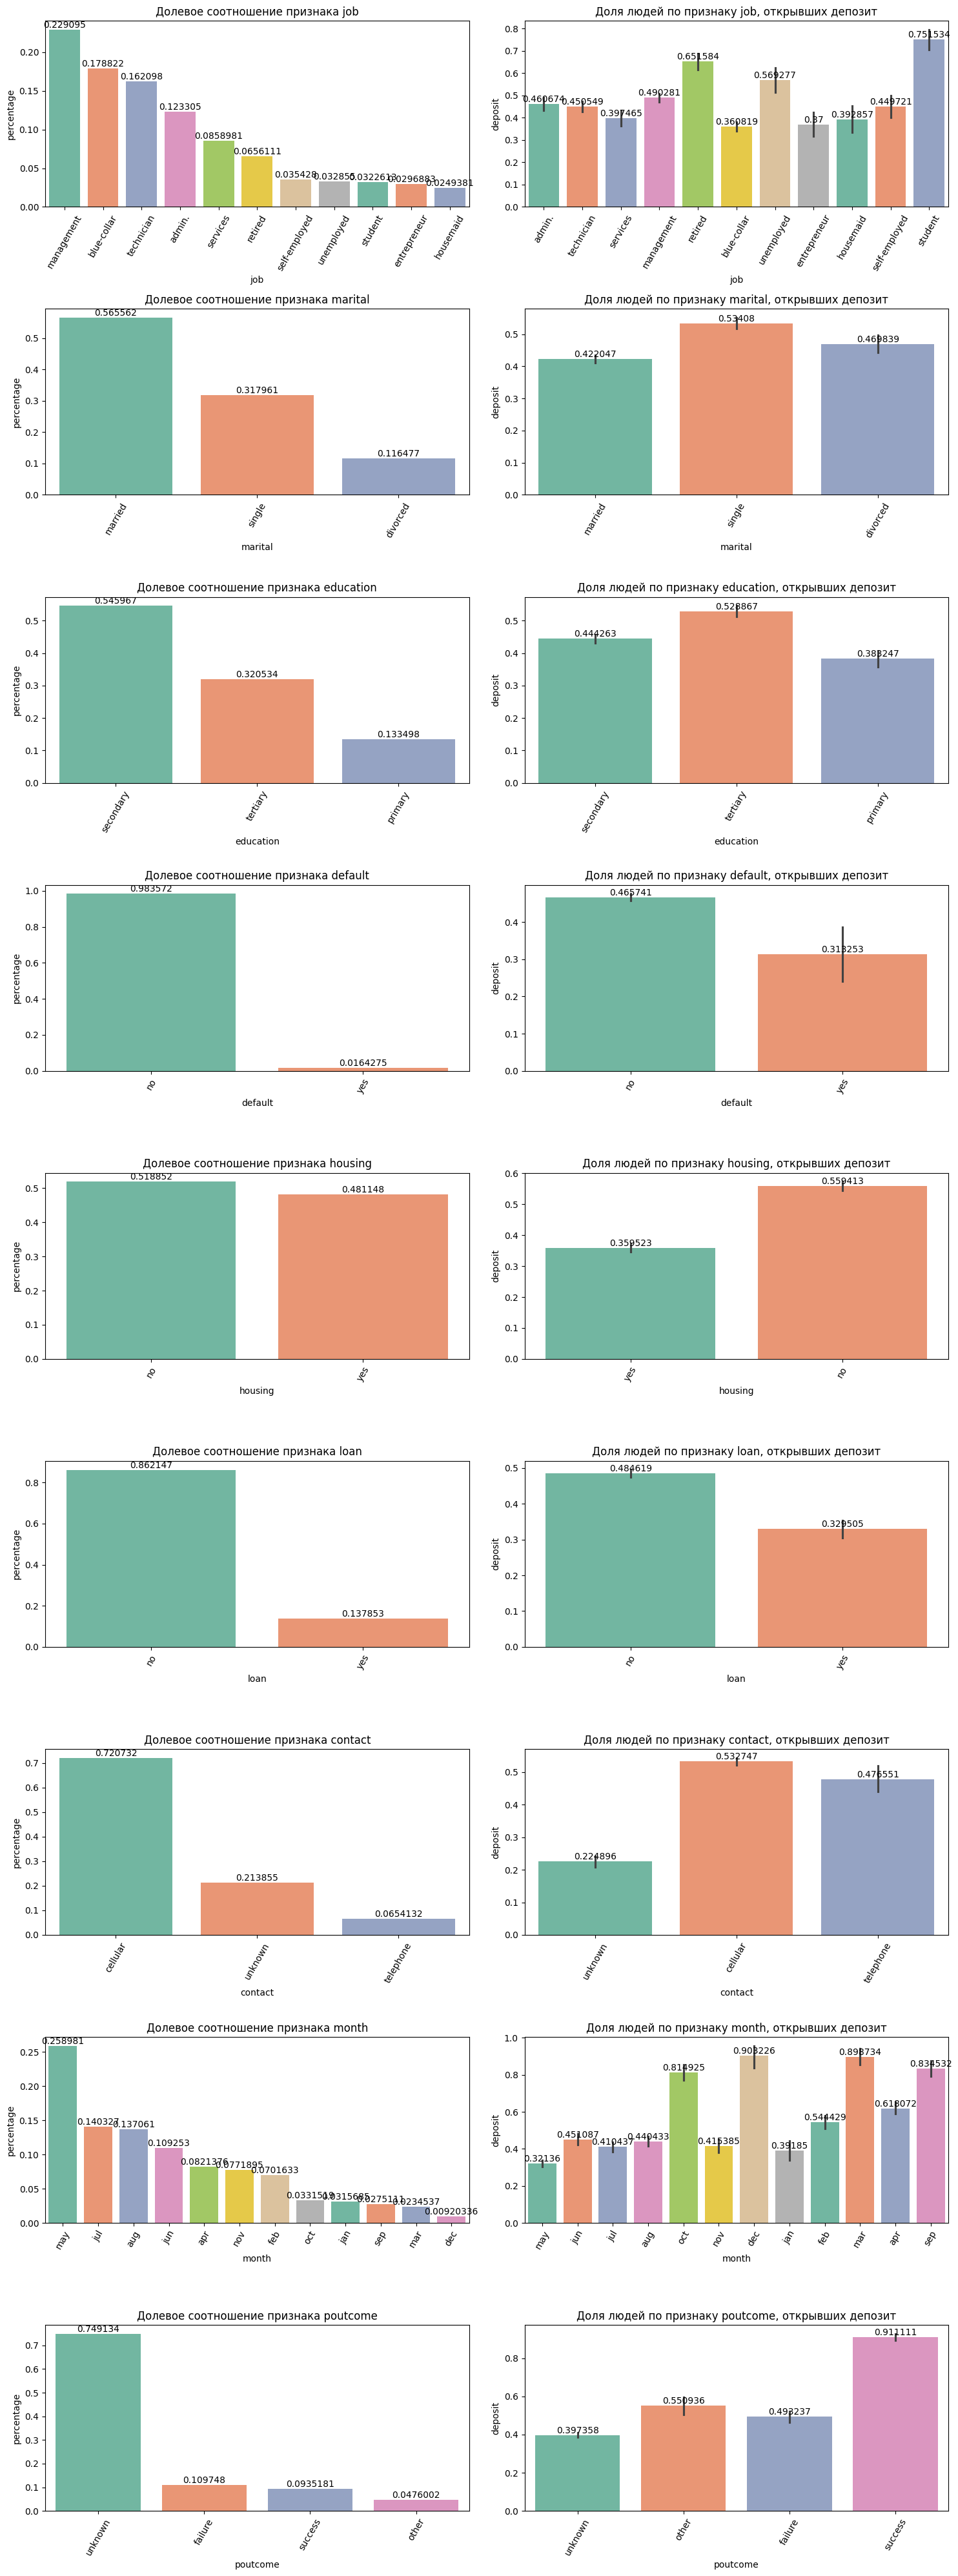

In [21]:

cat_features = df.select_dtypes(include=['object']).columns.tolist()

n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x=feature, y='percentage', ax=axes[i][0],palette='Set2')
    count_barplot.xaxis.set_tick_params(rotation=60)
    count_barplot.set_title(f'Долевое соотношение признака {feature}')
    #Строим столбчатую диаграмму доли людей открывших депозит (среднее по столбцу deposit) в зависимости от категории
    mean_barplot = sns.barplot(data=df, x=feature, y='deposit', ax=axes[i][1],palette='Set2', estimator='mean') #orient='y')
    mean_barplot.set_title(f'Доля людей по признаку {feature}, открывших депозит')
    mean_barplot.xaxis.set_tick_params(rotation=60)
    for container in axes[i][0].containers:
        axes[i][0].bar_label(container)
    for container in axes[i][1].containers:
        axes[i][1].bar_label(container)
plt.tight_layout() #выравнивание графиков

##### Узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. 

In [22]:
df.groupby(by='poutcome')['deposit'].mean().sort_values(ascending=False)

poutcome
success    0.911111
other      0.550936
failure    0.493237
unknown    0.397358
Name: deposit, dtype: float64

Видим, что успех предыдущей кампании очень завимит от успеха нынешней.

##### Теперь узнаем, какова зависимость результата маркетинговых кампаний от месяца.
Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

In [23]:
df.groupby(by='month')['deposit'].mean().sort_values(ascending=False)

month
dec    0.903226
mar    0.898734
sep    0.834532
oct    0.814925
apr    0.618072
feb    0.544429
jun    0.451087
aug    0.440433
nov    0.415385
jul    0.410437
jan    0.391850
may    0.321360
Name: deposit, dtype: float64

Видим, что проведение марккетинговой кампании в мае, а также летние месяцы и январь не являются эффективными.

#### Посмотрим на зависимость депозитов от возраста

Нам бы очень хотелось посмотреть, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. В аналитике принято разделять людей по возрастным подгруппам и делать выводы уже по ним. 

In [24]:
# Создадим функцию для деления возрастов по группам
def age_group(age):
    if age < 30:
        return '<30'
    elif age >= 30 and age <40:
        return '30-40'
    elif age >= 40 and age <50:
        return '40-50'
    elif age >= 50 and age <60:
        return '50-60'
    else: return '60+'

# Создадим новый признак с возрастными группами
df['age_group'] = df['age'].apply(age_group)

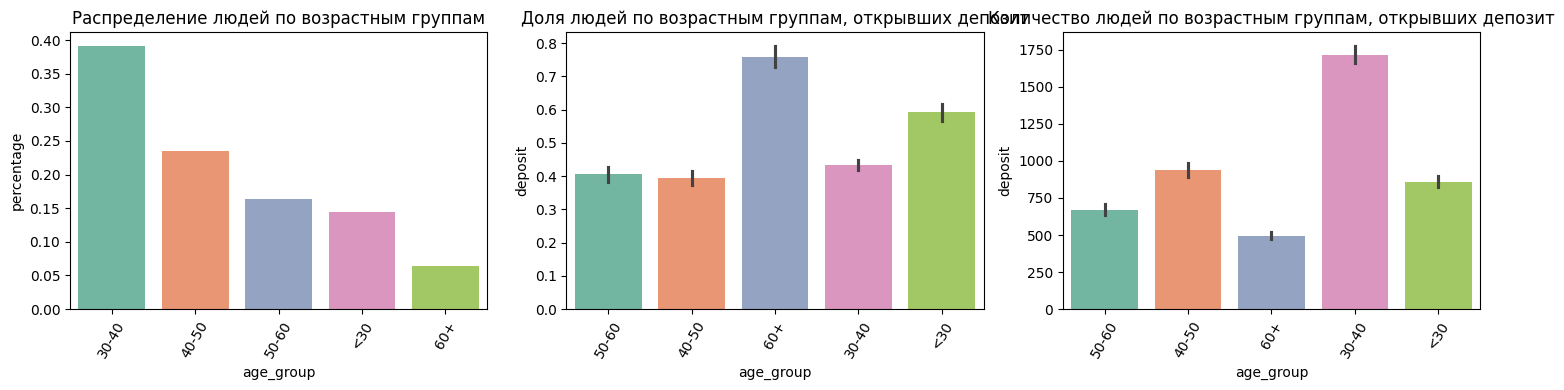

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4)) #фигура + 2 координатных плоскости
#Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
count_data = (df['age_group'].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
count_barplot = sns.barplot(data=count_data, x='age_group', y='percentage', ax=axes[0],palette='Set2')
count_barplot.xaxis.set_tick_params(rotation=60)
count_barplot.set_title('Распределение людей по возрастным группам')
#Строим столбчатую диаграмму доли людей открывших депозит (среднее по столбцу deposit) в зависимости от категории
mean_barplot = sns.barplot(data=df, x='age_group', y='deposit', ax=axes[1],palette='Set2', estimator='mean') #orient='y')
mean_barplot.set_title(f'Доля людей по возрастным группам, открывших депозит')
mean_barplot.xaxis.set_tick_params(rotation=60)
sum_barplot = sns.barplot(data=df, x='age_group', y='deposit', ax=axes[2],palette='Set2', estimator='sum') #orient='y')
sum_barplot.set_title(f'Количество людей по возрастным группам, открывших депозит')
sum_barplot.xaxis.set_tick_params(rotation=60)

plt.tight_layout() #выравнивание графиков

Можем увидеть, что депозиты чаще открывают молодые люди и пенсионеры, чем другие возрастные категории. Но в численном выражении больше депозитов открыли люди в возрасте 30-40 лет, хотя это и самая распространенная категория людей и только чуть более 40% таких людей открывает депозиты.

Также одинокие и разведенные люди чаще открывают депозит, чем женатые.
Студенты и пенсионеры чаще открывают депозит, чем другие категории, что коррелирует с утверждением выше.

Кроме того, люди с высшим образованием окрывают депозиты чаще, чем люди со средним и начальным, так что, скорее всего, финансовая грамотность коррелирует с уровнем образования. А может быть люди с высшим образованием больше зарабатывают и могут позволить откладывать свободные деньги.

### Зависимость открытия депозитов от семейного положения и образования

Мы посмотрели различные категории отдельно. Но что будет, если посмотреть на пересечения категорий? Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

Разделим таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части постротм сводную диаграмму по уровню образования и семейному положению, а результаты представим в виде тепловых карт.

In [26]:
df_yes = df[df['deposit']==1]
df_no = df[df['deposit']==0]

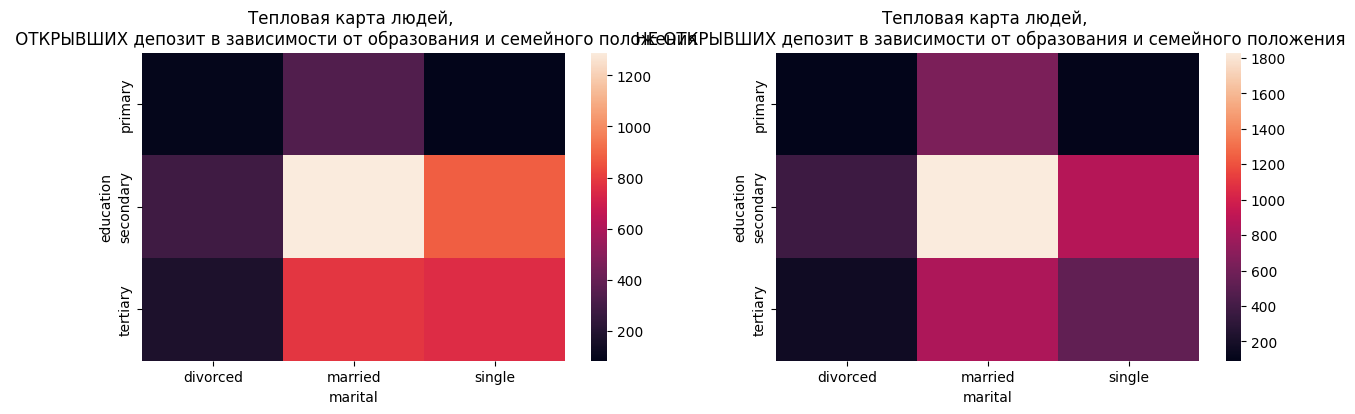

In [27]:
# Создадим сводные таблицы с количеством/отсутствием депозитов по сетке образование/семейное положение
deposit_yes = pd.pivot_table(pd.DataFrame(df_yes),
                        values='deposit', index='education',
                        columns='marital', aggfunc='count')
deposit_no = pd.pivot_table(pd.DataFrame(df_no),
                        values='deposit', index='education',
                        columns='marital', aggfunc='count')
# Визуализируем в виде тепловых карт
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4)) #фигура + 2 координатных плоскости
heatmap_yes = sns.heatmap(deposit_yes, ax=axes[0])
heatmap_yes.set_title('Тепловая карта людей, \n ОТКРЫВШИХ депозит в зависимости от образования и семейного положения')
heatmap_no = sns.heatmap(deposit_no, ax=axes[1])
heatmap_no.set_title('Тепловая карта людей, \n НЕ ОТКРЫВШИХ депозит в зависимости от образования и семейного положения');


In [28]:
deposit_yes

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


В целом, ситуации похожи. Одни и те же группы людей и открывают, и не открывают депозит в похожем соотношении. Если говорить про открывших депозит, в боьшинстве это либо женатые/не женатые люди  с высшим/средним образованием.

## Часть 3: преобразование данных

Перед тем как перейти к построению модели, осталось сделать ещё один шаг.  
Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить качество модели.  
Надо отобрать признаки, которые будем использовать для обучения модели.

### Признак Education

Этот признак является порядковым категориальным, поэтому закодирум его с помощью порядкового кодирования.

In [29]:
LE=LabelEncoder()
df['education'] = LE.fit_transform(df['education'])
df['education'].value_counts()

education
1    5517
2    3239
0    1349
Name: count, dtype: int64

### Признак Age_group

Аналогично закодируем признак с возрастными категориями. Признак порядковый, используем порядковое кодирование.


In [30]:
ord_encoder = OrdinalEncoder(categories=[['<30', '30-40','40-50',
                                          '50-60','60+']])

df['age_group'] = ord_encoder.fit_transform(df[['age_group']])
# Удалим исходный признак Age
df = df.drop('age',axis=1)

##### Преобразуем бинарные переменные в представление из нулей и единиц

In [31]:
df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)

### Теперь закодируем номинальные категориальные признаки 

In [32]:
df

,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,3.0
1,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,3.0
2,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,2.0
3,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,3.0
4,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,blue-collar,single,0,0,1.0,1,0,cellular,20,apr,257,1,-1,0,unknown,0,1.0
10101,services,married,1,0,733.0,0,0,unknown,16,jun,83,4,-1,0,unknown,0,1.0
10102,technician,single,1,0,29.0,0,0,cellular,19,aug,156,2,-1,0,unknown,0,1.0
10103,technician,married,1,0,0.0,0,1,cellular,8,may,9,2,172,5,failure,0,2.0


In [33]:
feach_dummies = pd.get_dummies(df, columns=['job','marital','contact','month','poutcome'])

In [34]:
feach_dummies.head()

,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1,0,2343.0,1,0,5,1042,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
1,1,0,45.0,0,0,5,1467,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
2,1,0,1270.0,1,0,5,1389,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
3,1,0,2476.0,1,0,5,579,1,-1,0,...,False,False,True,False,False,False,False,False,False,True
4,2,0,184.0,0,0,5,673,2,-1,0,...,False,False,True,False,False,False,False,False,False,True


### Оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

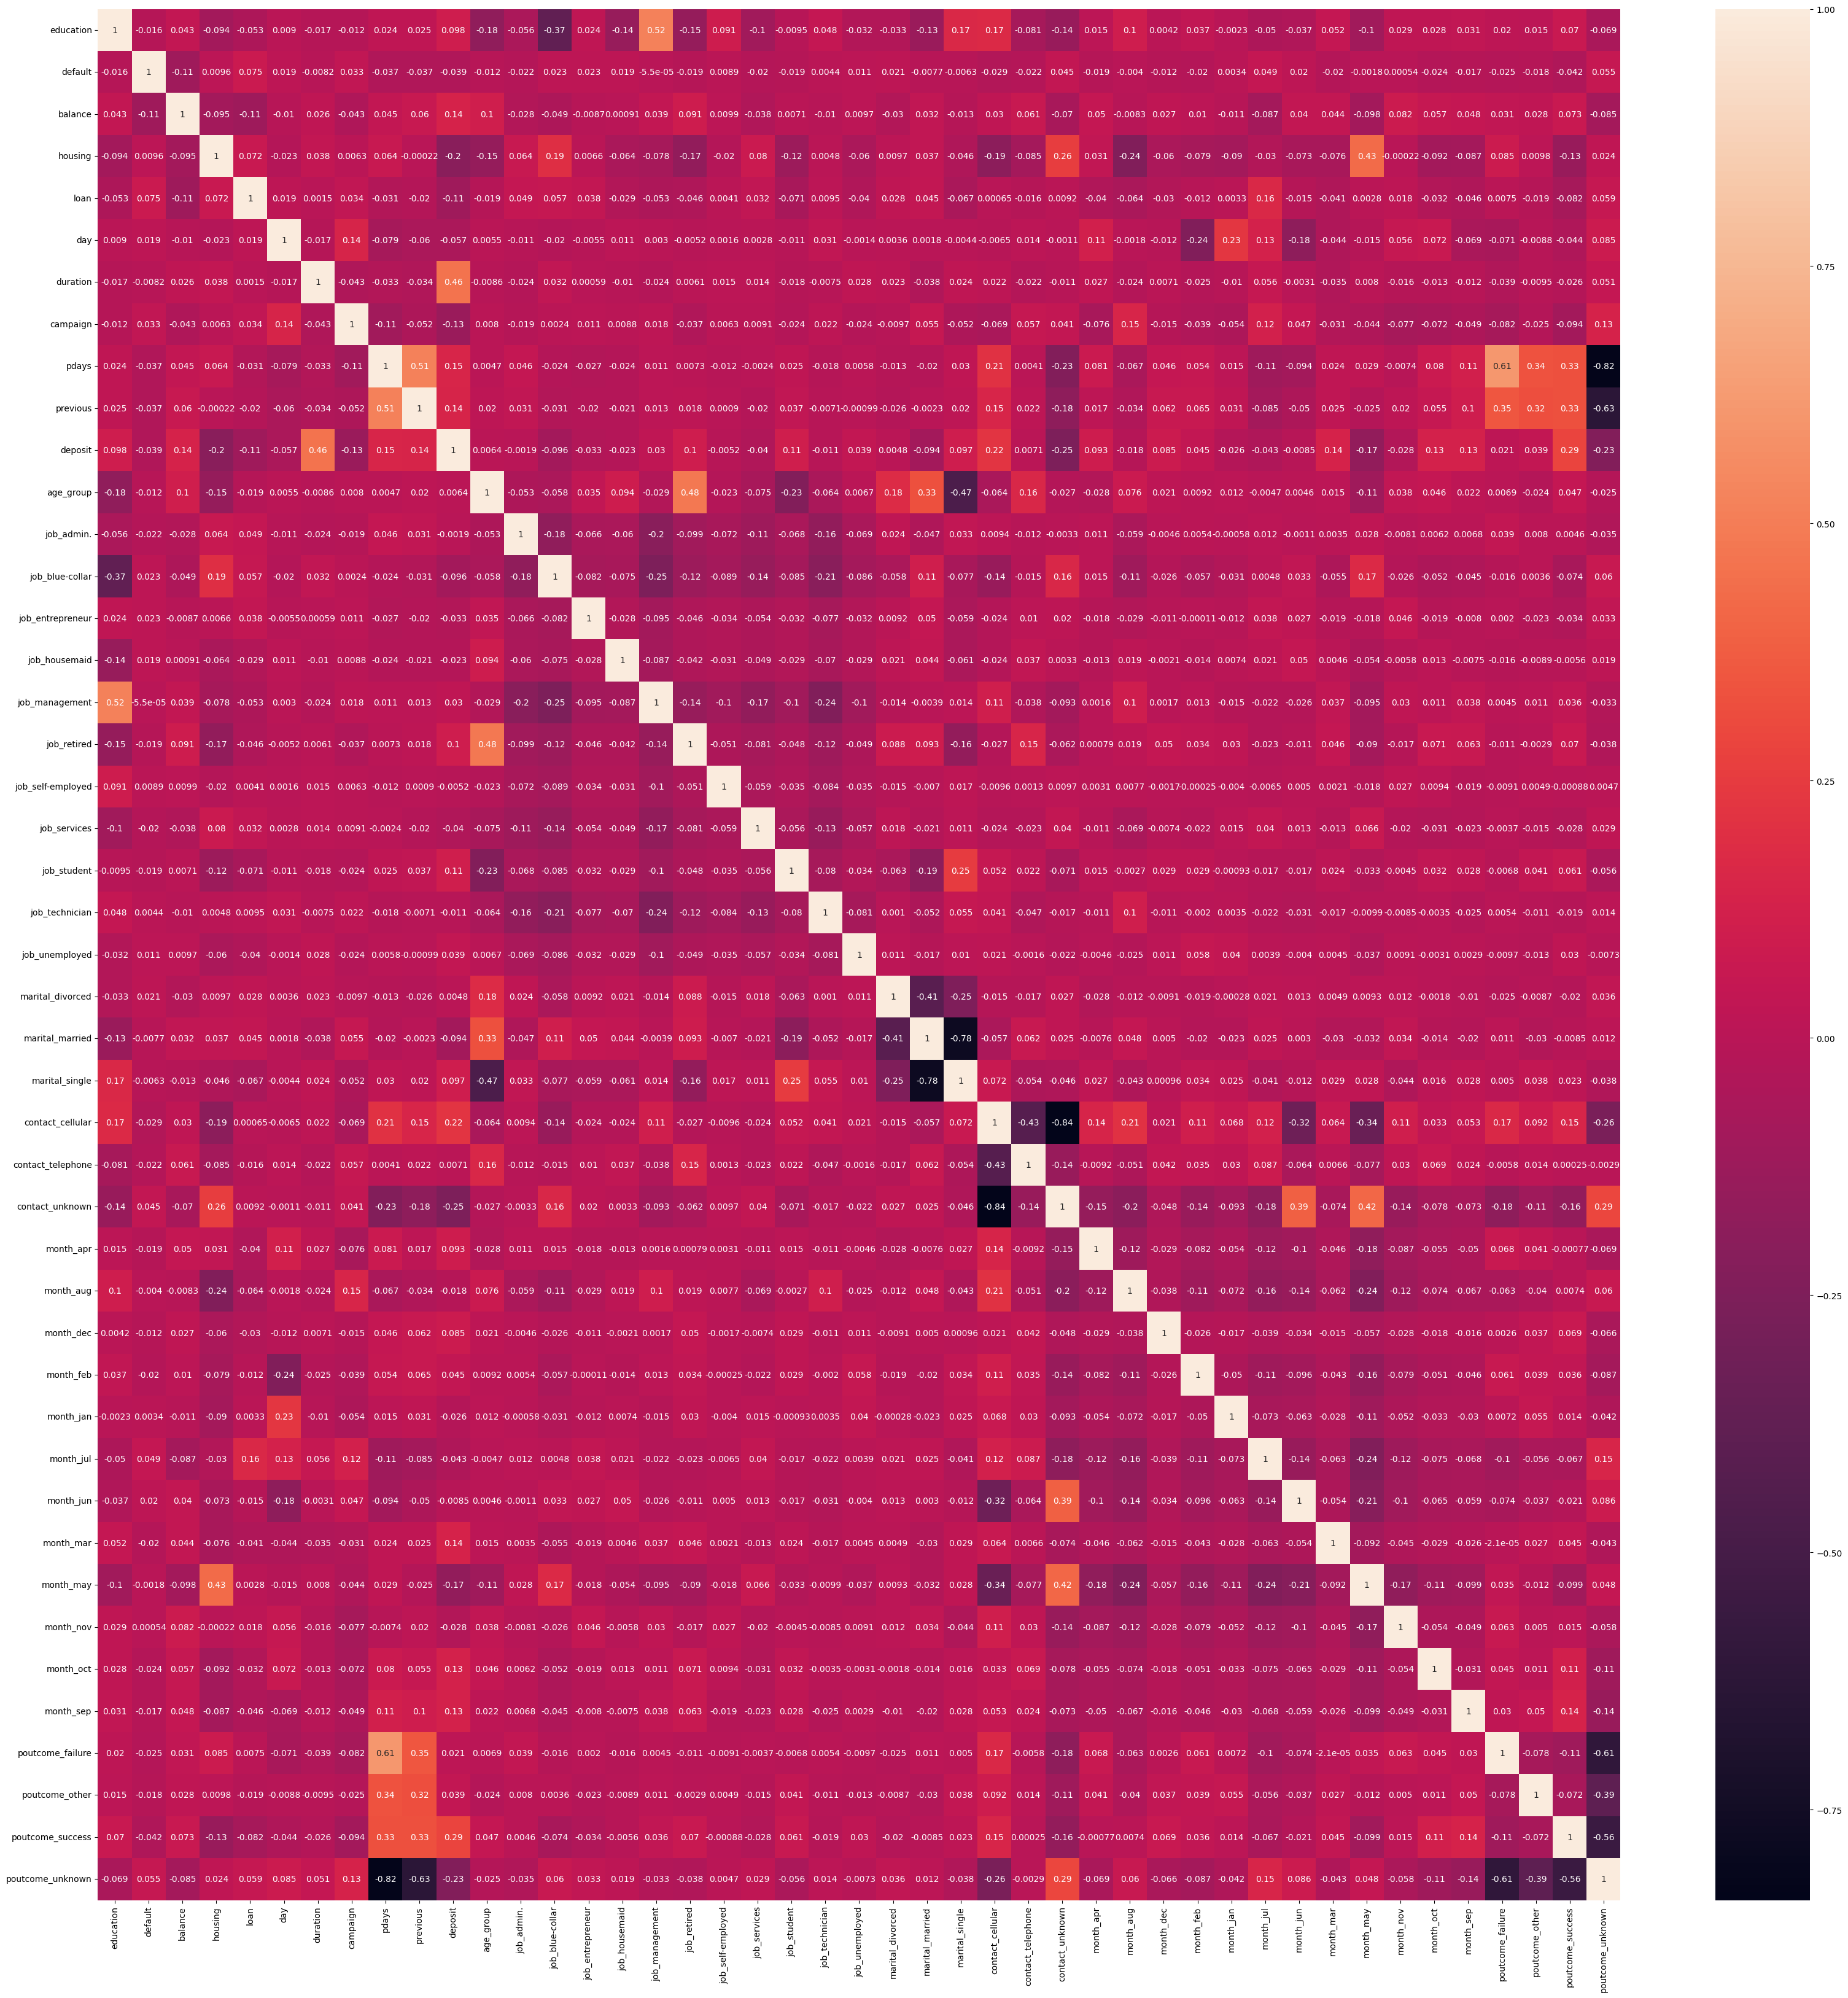

In [35]:
plt.figure(figsize = (40, 40))
sns.heatmap(feach_dummies.corr(numeric_only=True), annot = True);

С целевой переменной мультиколлинеарность не наблюдается. Есть корреляция признаков женат/не женат, и еще пары признаков, но пока в первом приближении оставим их.

### Разделим данные на обучающую и тестовую выборки

In [36]:
X = feach_dummies.drop(['deposit'], axis=1)
y = feach_dummies['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

#### Отбор признаков для обучения


На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберем 15 признаков, наилучшим образом подходящих для использования в задаче. 

In [37]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [38]:
cols_for_study = selector.get_feature_names_out()
X_train = X_train[cols_for_study]
X_test = X_test[cols_for_study]

### Нормализация данных

Нормализуем данные с помощью minmaxsxaler

In [39]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=cols_for_study)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=cols_for_study)


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

###  Модель логистической регрессии

Обучим модель логистической регрессии и рассчитаем метрики качества

In [40]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(solver='sag',max_iter = 1000, random_state=42)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
#Предсказываем результаты
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)
# Считаем метрики
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('accuracy на тренировочном наборе: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))


f1_score на тренировочном наборе: 0.80
f1_score на тестовом наборе: 0.78
accuracy на тренировочном наборе: 0.82
accuracy на тестовом наборе: 0.80


### Теперь обучим ещё один алгоритм — решающие деревья

In [41]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(criterion='entropy',
                                 random_state=42,  
                                 max_depth=6,
                                 min_samples_split=10)
#Обучаем дерево по алгоритму CART
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train_scaled)
y_test_pred = dt.predict(X_test_scaled)
# Считаем метрики
print('f1_score на тренировочном наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('accuracy на тренировочном наборе: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 0.79
f1_score на тестовом наборе: 0.78
accuracy на тренировочном наборе: 0.82
accuracy на тестовом наборе: 0.80


Налицо переобучение. Попробуем подобрать оптимальные гиперпараметры модели с помощью GridSearch.

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10] ,#мин кол-во объектов в листе
              'max_depth':[3,5,7], #глубина дерева
              }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 

print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 188 ms
Wall time: 4.69 s
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


In [43]:
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))

accuracy на тестовом наборе: 0.80


In [44]:
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Обучим модель случайного леса

In [45]:
from sklearn.metrics import classification_report
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(n_estimators=100,
                                     criterion='gini',
                                     min_samples_leaf=5,
                                     max_depth=10,
                                     random_state=42)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Теперь попробуем модель градиентного бустинга

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
                    learning_rate = 0.05, # темп обучения   
                    n_estimators = 300, #количество деревьев в ансамбле
                    min_samples_leaf = 5, # мин количество объектов в листе
                    max_depth = 5, #максимальная глубина дерева
                    random_state = 42
)

# Обучаем модель
gb.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_train_pred = gb.predict(X_train_scaled)
y_test_pred = gb.predict(X_test_scaled)

# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Попробуем использовать стекинг, объединив те алгоритмы, которые уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используем модель логистической регрессии.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier

In [48]:
from sklearn.ensemble import StackingRegressor
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestRegressor

# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('log_reg', log_reg),
    ('dt',  dt),
    ('gb', gb)
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42)
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('log_reg',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_split=10,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [49]:
# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test_scaled)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred_stack))
print('precision на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_pred_stack)))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.83      0.83      3335

precision на тестовом наборе: 0.81


### Задание 5

In [50]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Попробуем подобрать оптимальные гиперпараметры с помощью Optuna

Для перебора выберем случайный лес

In [51]:
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
    max_depth = trial.suggest_int('max_depth', 10, 30, 1);
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))

    return score

In [52]:
import optuna

# cоздаем объект исследования
# напрямую укажем, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2025-09-22 22:14:35,032] A new study created in memory with name: RandomForestClassifier
[I 2025-09-22 22:14:36,183] Trial 0 finished with value: 0.845889340418881 and parameters: {'n_estimators': 186, 'max_depth': 22, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.845889340418881.
[I 2025-09-22 22:14:37,130] Trial 1 finished with value: 0.8659600997506235 and parameters: {'n_estimators': 146, 'max_depth': 25, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8659600997506235.
[I 2025-09-22 22:14:38,234] Trial 2 finished with value: 0.8513618677042802 and parameters: {'n_estimators': 198, 'max_depth': 24, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8659600997506235.
[I 2025-09-22 22:14:39,315] Trial 3 finished with value: 0.8562548562548563 and parameters: {'n_estimators': 162, 'max_depth': 13, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8659600997506235.
[I 2025-09-22 22:14:39,998] Trial 4 finished with value: 0.8452287990004685 and parameters: {'n_es

In [53]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 140, 'max_depth': 17, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.90


In [54]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.81
accuracy на тестовом наборе: 0.82


## **Вывод**

Итак, в ходе работы были выполнены все этапы проекта.

**1.** **Первичная обработка данных.**
Данные были изучены, приведены к виду, с котовым можно работать в дальнейшем (удалены лишние символы). Данные проверены на предмет пропусков. Помимо явных пропусков (как в признаке Balance), наблюдались неявные пропуски в категориальных признаках (Education, Job). Для числового признака пропуски были заменены медианным значением, а для категориальных - модальным. 

**2. Разведывательный анализ данных (EDA).**
На втором этапе были изучены описательные статистики для категориальных и числовых признаков. Построены графики для визуализации распределения и взаимосвязи между числовыми признаками, а также для категориальных построены столбчатые диаграммы распределения признака по категориям и соотношения людей в каждой категории в зависимости от целевого признака (какая доля людей в каждой категории признака открыла депозит). 
Мы увидели, что депозиты чаще открывают молодые люди и пенсионеры, чем другие возрастные категории. Но в численном выражении больше депозитов открыли люди в возрасте 30-40 лет, хотя это и самая распространенная категория людей и только чуть более 40% таких людей открывает депозиты.
Также одинокие и разведенные люди чаще открывают депозит, чем женатые.
Студенты и пенсионеры чаще открывают депозит, чем другие категории, что коррелирует с утверждением выше.
Кроме того, люди с высшим образованием окрывают депозиты чаще, чем люди со средним и начальным, так что, скорее всего, финансовая грамотность коррелирует с уровнем образования. А может быть люди с высшим образованием больше зарабатывают и могут позволить откладывать свободные деньги.
В комбинации людей по уровню образования и семеному статусу в разрезе целевого признака однозначные выводы сделать трудно. Между комбинациями этих признаков есть корреляция: одни и те же группы как открывают депозиты, так и не открывают.

**3. Преобразование данных**
На этом этапе были выполнены некоторые преобразования признаков, например из признака возраста для удобства анализа был сформирован признак с возрастными категориями, т.к. сам по себе признак возраста имеет много уникальных значений и не похходит для работы.
Также для подачи данных в модель машинного обучения данные были закодированы. Порядковые категориальные переменные закодированы с помощью порядкового кодирования, номинальные - с помощью однократного кодирования. 
Кроме того, значения бинарных переменные были выражены через 1 и 0.

**4. Решение задачи классификации: логистическая регрессия и решающие деревья**
задача регрессии была решена с помощью двух моделей: линейной регрессии и дерева решений. Обе модели показали одинаковые метрики f1-score (0.78) и accuracy(0.80) (при учете подбора оптимальных гиперпараметров для модели дерева решений с помощью метода GridSearch, т.к. без этого модель предсказуемо ушла в переобучение)

**5. Ансамбли моделей и построение прогноза**
На этом этапе задача решалась более сложными моделями - с помощью моделей случайного леса и градиентвного бустинга над деревом решений. Модель градиентного бустинга показала метрики f1-score = 0.81 и accuracy = 0.82. Чуть лучше справилась модель случайного леса, f1-score = 0.82 и accuracy = 0.83. В целом модель одинакого хорошо определяет отношение к классу 1 и к классу 0, т.к. выборка данных была сбалансирована по целевому признаку.
Кроме того, был проверен алгоритм стекинга. В качестве базовых моделей применялись алгоритмы, которые уже использовали ранее: решающие деревья, логистическая регрессия и градиентный бустинг. В качестве метамодели использовалась модель логистической регрессии. Результаты получились аналогичны модели случайного леса.
Также, для модели случайного леса были подобраны оптимальные гиперпараметры с помощью Optuna. Однако, после обучения модели на оптимальных гиперпараметрах поднять качество не удалось, метрики остались на прежних значениях.

**Итого, задача решена, теперь модель по имеющимся признакам клиентов может с высоким качеством предстказать, откроет клиент депозит или нет.**